In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error


# ----------------- Load & Normalize Data -----------------
df = pd.read_csv("data/DayAheadSpotPrices.csv")
series = df["2017"].dropna().values.flatten()[3000:5000]  # original slice
#series = df["2017"].dropna().values.flatten()


# Normalize the series
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series.reshape(-1, 1)).flatten()

# ----------------- Create Supervised Sequences -----------------
def create_fixed_window_data(data, input_len=169, output_len=168):
    X, y = [], []
    for i in range(input_len, len(data) - output_len + 1):
        X.append(data[i - input_len:i])
        y.append(data[i:i + output_len])
    return np.array(X), np.array(y)

input_len = 169
output_len = 168
X, y = create_fixed_window_data(series_scaled, input_len, output_len)

# ----------------- Train/Val Split -----------------
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)

# ----------------- Neural Network Model with Dropout -----------------
class PricePredictor(nn.Module):
    def __init__(self, input_dim=169, output_dim=168):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, output_dim)
        )

    def forward(self, x):
        return self.net(x)

model = PricePredictor()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # 👈 Lowered LR
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
loss_fn = nn.MSELoss()

# ----------------- Training -----------------
for epoch in range(200):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()

    scheduler.step()

    # Validation Loss (optional but useful)
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_tensor)
            val_loss = loss_fn(val_pred, y_val_tensor)
        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch {epoch}: Train Loss = {loss.item():.4f}, Val Loss = {val_loss.item():.4f}, LR = {current_lr:.6f}")


Epoch 0: Train Loss = 0.0453, Val Loss = 0.0200, LR = 0.000100
Epoch 10: Train Loss = 0.0223, Val Loss = 0.0122, LR = 0.000100
Epoch 20: Train Loss = 0.0192, Val Loss = 0.0181, LR = 0.000050
Epoch 30: Train Loss = 0.0169, Val Loss = 0.0134, LR = 0.000050
Epoch 40: Train Loss = 0.0186, Val Loss = 0.0136, LR = 0.000025
Epoch 50: Train Loss = 0.0173, Val Loss = 0.0158, LR = 0.000025
Epoch 60: Train Loss = 0.0153, Val Loss = 0.0124, LR = 0.000013
Epoch 70: Train Loss = 0.0165, Val Loss = 0.0127, LR = 0.000013
Epoch 80: Train Loss = 0.0148, Val Loss = 0.0135, LR = 0.000006
Epoch 90: Train Loss = 0.0176, Val Loss = 0.0142, LR = 0.000006
Epoch 100: Train Loss = 0.0151, Val Loss = 0.0138, LR = 0.000003
Epoch 110: Train Loss = 0.0139, Val Loss = 0.0136, LR = 0.000003
Epoch 120: Train Loss = 0.0125, Val Loss = 0.0139, LR = 0.000002
Epoch 130: Train Loss = 0.0155, Val Loss = 0.0143, LR = 0.000002
Epoch 140: Train Loss = 0.0125, Val Loss = 0.0136, LR = 0.000001
Epoch 150: Train Loss = 0.0153, Val 

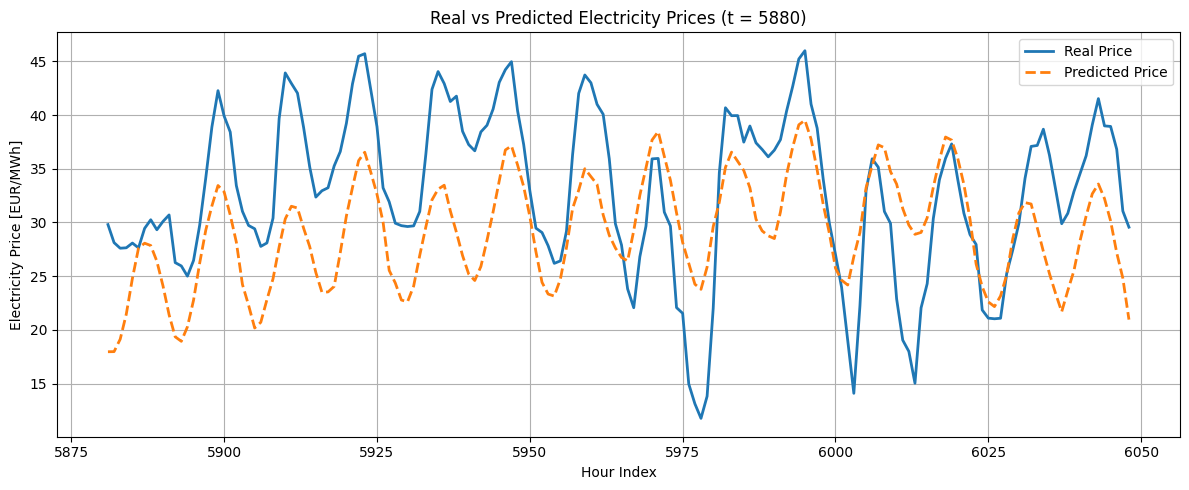

In [3]:
# ----------------- Inference & Plotting for t_abs = 5882 -----------------

# Use the full (already loaded) series
series = df["2017"].dropna().values.flatten()
series_scaled = scaler.transform(series.reshape(-1, 1)).flatten()

# Choose absolute index for prediction
t_abs = 5880

# Ensure valid indexing
if t_abs - 168 < 0 or t_abs + 168 >= len(series):
    raise ValueError("t_abs is out of bounds for prediction range.")

# Prepare model input: last 169 points before t_abs
input_seq = torch.tensor(series_scaled[t_abs - 168 : t_abs + 1], dtype=torch.float32).unsqueeze(0)  # [1, 169]

# Run prediction
model.eval()
with torch.no_grad():
    predicted_norm = model(input_seq).squeeze().numpy()

# Inverse transform predicted prices to real values
predicted_prices = scaler.inverse_transform(predicted_norm.reshape(-1, 1)).flatten()

# True future prices (real, not scaled)
real_prices = series[t_abs + 1 : t_abs + 1 + 168]

# Save predicted prices to CSV
pd.DataFrame(predicted_prices).to_csv("data/PredictedPrices.csv", index=False, header=False)

# Plot results
time_range = np.arange(t_abs + 1, t_abs + 1 + 168)

plt.figure(figsize=(12, 5))
plt.plot(time_range, real_prices, label="Real Price", linewidth=2)
plt.plot(time_range, predicted_prices, '--', label="Predicted Price", linewidth=2)
plt.xlabel("Hour Index")
plt.ylabel("Electricity Price [EUR/MWh]")
plt.title(f"Real vs Predicted Electricity Prices (t = {t_abs})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
# ----------------- Calculate Error Metrics -----------------

# Calculate errors
mse = mean_squared_error(real_prices, predicted_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(real_prices, predicted_prices)



print(f"Prediction Error Metrics:")
print(f" - RMSE: {rmse:.4f} EUR/MWh")
print(f" - MAE: {mae:.4f} EUR/MWh")


Prediction Error Metrics:
 - RMSE: 7.2595 EUR/MWh
 - MAE: 6.4002 EUR/MWh
